In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.random import default_rng
rng = default_rng()

def bootstrap(perfRuntimes1: pd.DataFrame, perfRuntimes2: pd.DataFrame):
  numberOfIterations = 5
  instanceRunsNumber = 3
  instanceRuns = range(1, instanceRunsNumber)
  suiteRunsNumber = 3
  suiteRuns = range(1,suiteRunsNumber)
  numberOfSamples = 10000
  allRuntimes1 = np.ndarray((instanceRunsNumber, suiteRunsNumber, numberOfIterations))
  allRuntimes2 = np.ndarray((instanceRunsNumber, suiteRunsNumber, numberOfIterations))

  for instanceRun in instanceRuns:
    for suiteRun in suiteRuns:
        prefix = f"{instanceRun}-{suiteRun}-"
        allRuntimes1[instanceRun][suiteRun] = perfRuntimes1.loc[(perfRuntimes1['R-S-I'].str.startswith(prefix)),'sec/op'].to_numpy()
        allRuntimes2[instanceRun][suiteRun] = perfRuntimes2.loc[(perfRuntimes2['R-S-I'].str.startswith(prefix)),'sec/op'].to_numpy()

  #Generate random arrays
  currentInstanceRun = rng.choice(instanceRuns, size=(instanceRunsNumber, numberOfSamples))
  currentSuiteRun = rng.choice(suiteRuns, size=(suiteRunsNumber, instanceRunsNumber, numberOfSamples))
  currentRuntimes1 = rng.integers(numberOfIterations, size=(numberOfIterations, suiteRunsNumber, instanceRunsNumber, numberOfSamples))
  currentRuntimes2 = rng.integers(numberOfIterations, size=(numberOfIterations, suiteRunsNumber, instanceRunsNumber, numberOfSamples))

  #Bulk selection
  tmp1 = allRuntimes1[currentInstanceRun, currentSuiteRun, currentRuntimes1]
  tmp1 = np.stack(tmp1, axis=3).reshape((numberOfSamples, suiteRunsNumber * instanceRunsNumber * numberOfIterations))
  tmp2 = allRuntimes2[currentInstanceRun, currentSuiteRun, currentRuntimes2]
  tmp2 = np.stack(tmp2, axis=3).reshape((numberOfSamples, suiteRunsNumber * instanceRunsNumber * numberOfIterations))

  # Get median for both lists
  med1 = np.median(tmp1, axis=1)
  med2 = np.median(tmp2, axis=1)
  R = med2/med1
  R.sort()

  CIsmall = 1 # 99% confidence interval
  small = int((numberOfSamples * CIsmall) / 100 / 2)
  if small == 0: small = 1
  minSmall = R[small-1]
  minSmall = (minSmall - 1) * 100
  maxSmall = R[numberOfSamples-small-1]
  maxSmall = (maxSmall - 1) * 100
  instability = maxSmall - minSmall
  refData = (R-1) * 100
  return refData, minSmall, maxSmall, instability

In [17]:
def compareVersionsForBenchmark(fnName: str):
    foundBenchmark = df[df["package.BenchmarkFunction"] == fnName]
    runtimes1 = foundBenchmark[foundBenchmark["Version"] == 1]
    runtimes2 = foundBenchmark[foundBenchmark["Version"] == 2]
    assert runtimes1.shape[0] == 45
    assert runtimes2.shape[0] == 45
    median1 = runtimes1['sec/op'].median()
    median2 = runtimes2['sec/op'].median()
    change = ((median2/median1) - 1) * 100
    refData, minci, maxci, instability = bootstrap(runtimes1, runtimes2)
    assert maxci > change
    assert change > minci
    print(f"[{fnName}] performance change: {change:.2f}% [{minci:.2f} - {maxci:.2f}] ({instability:.2f}%)")
    return {
        'benchFn': fnName,
        'change': change,
        'minci': minci,
        'maxci': maxci,
        'refData': refData
    }

In [32]:
columnNames = ["R-S-I", "package.BenchmarkFunction", "Version", "Directory", "Iterations", "sec/op", "B/op", "allocs/op"]

# benchmarkName = "mb-main-main-2022-11-18T14:43:02+01:00"
# benchmarkName = "mb-main-perf-issue-basic-auth-2022-11-18T17:53:02+01:00"
# benchmarkName = "mb-main-perf-issue-clean-path-2022-11-18T15:48:32+01:00"
# benchmarkName = "mb-main-perf-issue-request-id-2022-11-18T16:51:40+01:00"
#
# benchmarkName = "mb-opt-main-main-2022-11-18T19:04:25+01:00"
# benchmarkName = "mb-opt-main-perf-issue-basic-auth-2022-11-18T19:59:39+01:00"
# benchmarkName = "mb-opt-main-perf-issue-clean-path-2022-11-18T19:22:57+01:00"
benchmarkName = "mb-opt-main-perf-issue-request-id-2022-11-18T19:41:16+01:00"

benchmarkPrettyName = "-".join(benchmarkName.split("-")[:-3])
df = pd.read_csv(f"../results/fbs/{benchmarkName}/combined.csv", names=columnNames)
functionNames = df["package.BenchmarkFunction"].unique()
functionNames.sort()

bootstrapResults = []
for fnName in functionNames:
    bootstrapResults.append(compareVersionsForBenchmark(fnName))


bootstrapResults_df = pd.DataFrame(bootstrapResults)
bootstrapResults_df["benchmark"] = benchmarkPrettyName
bootstrapResults_df.to_csv(f"{benchmarkPrettyName}-bootstrap.csv", columns=["benchmark", "benchFn", "change", "minci", "maxci"], index=False)
bootstrapResults_df

[service.BenchmarkHandlerGetFlightSeats] performance change: 0.16% [-1.33 - 1.68] (3.01%)
[service.BenchmarkRequestCreateBooking] performance change: 5499.90% [5400.04 - 5575.03] (174.99%)
[service.BenchmarkRequestDestinations] performance change: 42.07% [39.97 - 43.32] (3.35%)
[service.BenchmarkRequestFlights] performance change: 222.25% [218.15 - 224.26] (6.11%)


,benchFn,change,minci,maxci,refData,benchmark
0,service.BenchmarkHandlerGetFlightSeats,0.157625,-1.326302,1.681154,"[-2.0587320079991644, -1.9819080608081352, -1....",mb-opt-main-perf-issue-request-id
1,service.BenchmarkRequestCreateBooking,5499.904131,5400.036879,5575.028317,"[5351.389844224154, 5355.695018003539, 5360.98...",mb-opt-main-perf-issue-request-id
2,service.BenchmarkRequestDestinations,42.074174,39.971338,43.318799,"[39.64631700837216, 39.64631700837216, 39.6785...",mb-opt-main-perf-issue-request-id
3,service.BenchmarkRequestFlights,222.251293,218.148917,224.260636,"[216.74478910932433, 216.82911597409708, 216.9...",mb-opt-main-perf-issue-request-id


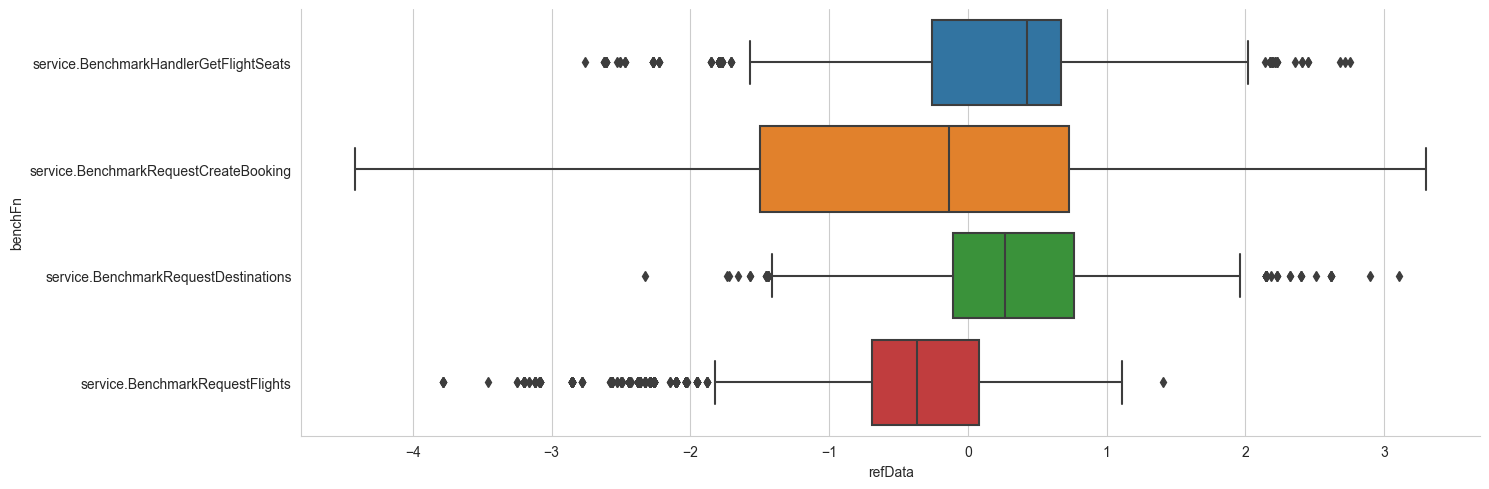

In [22]:
boxPlotDf = bootstrapResults_df.explode('refData')
g = sns.catplot(data=boxPlotDf, x="refData", y="benchFn", kind="box", aspect=3)
# g.savefig(f"{benchmarkPrettyName}-perf-change.pdf")
g